### Link to results
[Proportion of peaks with hits](#peaks-with-hits)

[Examples of motif hits](#example-hits)

[Homotypic density of motifs in peaks](#density)

[Co-occurrence of motifs in peaks](#co-occurrence)

[Distance between co-occurring motifs](#distance)

In [1]:
import os
from tfmodisco_hit_scoring import import_tfmodisco_hits
from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import viz_sequence
import h5py
import numpy as np
import pandas as pd
import pomegranate
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

/tmp/ipykernel_14335/850303109.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define constants and paths

In [157]:
# CTCF chipseq

# Define parameters/fetch arguments
tfm_results_path = "/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/tfmodisco_results"
shap_scores_path = "/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/shap_scores"
peak_bed_paths = ["/home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed"]
motif_hits_path = "/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_chipseq_feb7/tfm_matches.bed"
hits_cache_dir = "/home/katie/bp_repo/reports/motif_hits_cache/CTCF/ctcf_chipseq_feb7/"

print("TF-MoDISco results path: %s" % tfm_results_path)
print("DeepSHAP scores path: %s" % shap_scores_path)
print("Peaks path: %s" % peak_bed_paths[0])
print("Motif hits path: %s" % motif_hits_path)
print("Saved motif hits cache: %s" % hits_cache_dir)

TF-MoDISco results path: /home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/tfmodisco_results
DeepSHAP scores path: /home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/shap_scores
Peaks path: /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed
Motif hits path: /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_chipseq_feb7/tfm_matches.bed
Saved motif hits cache: /home/katie/bp_repo/reports/motif_hits_cache/CTCF/ctcf_chipseq_feb7/


In [41]:
# Constants
input_length = 2114
hyp_score_key = "hyp_scores"
motif_tfm_sim_perc_cutoff = 0.05  # For TF-MoDISco hits
motif_tfm_imp_perc_cutoff = 0.05  # For TF-MoDISco hits

seed = 20210412

In [158]:
if hits_cache_dir:
    os.makedirs(hits_cache_dir, exist_ok=True)

### Helper functions
For plotting and organizing things

In [6]:
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                    
                if trim:
                    pfm = trim_motif_by_ic(pfm, pfm)
                    
                pfms["%d_%d" % (metacluster_i,pattern_i)] = pfm
    return pfms

In [7]:
def import_motif_hits(motif_hits_path):
    """
    Imports the motif hits, which is the output of TF-MoDISco hit scanning.
    """
    with open(motif_hits_path, "r") as f:
        cols = next(f).split("\t")
    assert len(cols) == 16

    hit_table = import_tfmodisco_hits(motif_hits_path)

    # Sort by aggregate similarity and drop duplicates (by strand)
    hit_table = hit_table.sort_values("agg_sim")
    hit_table = hit_table.drop_duplicates(["chrom", "start", "end", "peak_index"], keep="last")
    return hit_table

In [8]:
def estimate_mode(x_values, bins=200, levels=1):
    """
    Estimates the mode of the distribution using `levels`
    iterations of histograms.
    """
    hist, edges = np.histogram(x_values, bins=bins)
    bin_mode = np.argmax(hist)
    left_edge, right_edge = edges[bin_mode], edges[bin_mode + 1]
    if levels <= 1:
        return (left_edge + right_edge) / 2
    else:
        return estimate_mode(
            x_values[(x_values >= left_edge) & (x_values < right_edge)],
            bins=bins,
            levels=(levels - 1)
        )

In [9]:
def fit_tight_exponential_dist(x_values, mode=0, percentiles=np.arange(0.05, 1, 0.05)):
    """
    Given an array of x-values and a set of percentiles of the distribution,
    computes the set of lambda values for an exponential distribution if the
    distribution were fit to each percentile of the x-values. Returns an array
    of lambda values parallel to `percentiles`. The exponential distribution
    is assumed to have the given mean/mode, and all data less than this mode
    is tossed out when doing this computation.
    """
    assert np.min(percentiles) >= 0 and np.max(percentiles) <= 1
    x_values = x_values[x_values >= mode]
    per_x_vals = np.percentile(x_values, percentiles * 100)
    return -np.log(1 - percentiles) / (per_x_vals - mode)

In [10]:
def exponential_pdf(x_values, lamb):
    return lamb * np.exp(-lamb * x_values)
def exponential_cdf(x_values, lamb):
    return 1 - np.exp(-lamb * x_values)

In [11]:
def filter_tfm_peak_hits(
    hit_table, sim_score_column="agg_sim", imp_score_column="imp_frac_score",
    sim_perc_cutoff=0.05, imp_perc_cutoff=0.05
):
    """
    Filters the table of peak hits by the score defined by
    `score_column` by filtering out low-percentile hits in terms of both
    similarity to the cluster, and importance score.
    For the similarity score, a mixed model is fit to the distribution of
    simiarities, and the low percentiles of the exponential component (the
    null) are cut off. For the importance score filter, a Gaussian null
    is fit to the part of the score distribution to the left of the mode
    (mirroring it around the mode), and then applying the percentile
    cut-off. Returns a reduced hit table of the same format, and a figure
    of the similarity distribution and the importance distribution.
    """
    # Similarity filtering
    
    sim_scores = hit_table[sim_score_column].values
    sim_scores_finite = sim_scores[np.isfinite(sim_scores)]
    
    sim_mode = estimate_mode(sim_scores_finite)
    sim_scores_below_mode = sim_scores_finite[sim_scores_finite <= sim_mode]
    sim_scores_symmetric = np.concatenate([sim_scores_below_mode, (2 * sim_mode) - sim_scores_below_mode])

    sim_null_model = pomegranate.NormalDistribution.from_samples(sim_scores_symmetric)
    sim_null_model.fit(sim_scores_symmetric)

    sim_x = np.linspace(np.min(sim_scores_symmetric), np.max(sim_scores_symmetric), 200)
    sim_pdf = sim_null_model.probability(sim_x)
    
    sim_score_fig, ax = plt.subplots(figsize=(20, 6))
    ax.hist(sim_scores_finite, bins=500, density=True, alpha=0.3, label="Similarity scores")
    ax.hist(sim_scores_symmetric, bins=500, density=True, alpha=0.3, label="Null component")
    ax.plot(sim_x, sim_pdf, label="Fitted null model")
    mean, std = sim_null_model.parameters
    sim_thresh = scipy.stats.norm.ppf(sim_perc_cutoff, mean, std)
    ax.axvline(sim_thresh)
    plt.legend()
    plt.show()
    
    # Importance score filtering
    
    imp_scores = hit_table[imp_score_column].values
    imp_scores_finite = imp_scores[np.isfinite(imp_scores)]

    imp_mode = estimate_mode(imp_scores_finite)
    imp_scores_below_mode = imp_scores_finite[imp_scores_finite <= imp_mode]
    imp_scores_symmetric = np.concatenate([imp_scores_below_mode, (2 * imp_mode) - imp_scores_below_mode])

    imp_null_model = pomegranate.NormalDistribution.from_samples(imp_scores_symmetric)
    imp_null_model.fit(imp_scores_symmetric)

    imp_x = np.linspace(np.min(imp_scores_symmetric), np.max(imp_scores_symmetric), 200)
    imp_pdf = imp_null_model.probability(imp_x)
    
    imp_score_fig, ax = plt.subplots(figsize=(20, 6))
    ax.hist(imp_scores_finite, bins=500, density=True, alpha=0.3, label="Importance scores")
    ax.hist(imp_scores_symmetric, bins=500, density=True, alpha=0.3, label="Null component")
    ax.plot(imp_x, imp_pdf, label="Fitted null model")
    mean, std = imp_null_model.parameters
    imp_thresh = scipy.stats.norm.ppf(imp_perc_cutoff, mean, std)
    ax.axvline(imp_thresh)
    plt.legend()
    plt.show()

    return hit_table.loc[
        (hit_table[sim_score_column] >= sim_thresh) & (hit_table[imp_score_column] >= imp_thresh)
    ].reset_index(drop=True), (sim_score_fig, imp_score_fig)

In [12]:
def get_peak_hits(peak_table, hit_table):
    """
    For each peak, extracts the set of motif hits that fall in that peak.
    Returns a list mapping peak index to a subtable of `hit_table`. The index
    of the list is the index of the peak table.
    """
    peak_hits = [pd.DataFrame(columns=list(hit_table))] * len(peak_table)
    for peak_index, matches in tqdm.notebook.tqdm(hit_table.groupby("peak_index")):
        # Check that all of the matches are indeed overlapping the peak
        peak_row = peak_table.iloc[peak_index]
        chrom, start, end = peak_row["chrom"], peak_row["peak_start"], peak_row["peak_end"]
        assert np.all(matches["chrom"] == chrom)
        assert np.all((matches["start"] < end) & (start < matches["end"]))
        
        peak_hits[peak_index] = matches
    return peak_hits

In [13]:
def get_peak_motif_counts(peak_hits, motif_keys):
    """
    From the peak hits (as returned by `get_peak_hits`), computes a count
    array of size N x M, where N is the number of peaks and M is the number of
    motifs. Each entry represents the number of times a motif appears in a peak.
    `motif_keys` is a list of motif keys as they appear in `peak_hits`; the
    order of the motifs M matches this list.
    """
    motif_inds = {motif_keys[i] : i for i in range(len(motif_keys))}
    counts = np.zeros((len(peak_hits), len(motif_keys)), dtype=int)
    for i in tqdm.notebook.trange(len(peak_hits)):
        hits = peak_hits[i]
        for key, num in zip(*np.unique(hits["key"], return_counts=True)):
            counts[i][motif_inds[key]] = num
    return counts

In [14]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

In [15]:
def plot_peak_motif_indicator_heatmap(peak_hit_counts, motif_keys, subsample=None):
    """
    Plots a simple indicator heatmap of the motifs in each peak.
    Returns the figure.
    """
    # Subsample peaks
    if subsample:
        peak_hit_counts = peak_hit_counts[np.random.choice(
            len(peak_hit_counts), size=min(len(peak_hit_counts), subsample), replace=False
        )]
        
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    
    # Order columns by prevalence (by number of peaks with that motif)
    counts = np.sum(peak_hit_indicators, axis=0)
    inds = np.flip(np.argsort(counts))
    matrix = peak_hit_indicators[:, inds]
    motif_keys = np.array(motif_keys)[inds]
    
    # Order rows in "binary" order
    places = np.power(2, np.flip(np.arange(matrix.shape[1])))
    values = np.sum(matrix * places, axis=1)
    inds = np.flip(np.argsort(values))
    matrix = matrix[inds]
    
    # Create a figure with the right dimensions
    fig_height = min(len(peak_hit_indicators) * 0.004, 8)
    fig, ax = plt.subplots(figsize=(16, fig_height))

    # Plot the heatmap
    ax.imshow(matrix, interpolation="nearest", aspect="auto", cmap="Greens")

    # Set axes on heatmap
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(len(motif_keys)))
    ax.set_xticklabels(motif_keys)
    ax.set_xlabel("Motif")

    fig.tight_layout()
    plt.show()
    return fig

In [16]:
def plot_homotypic_densities(peak_hit_counts, motif_keys):
    """
    Plots a CDF of number of motif hits per peak, for each motif.
    Returns a dictionary mapping motif key to figure.
    """
    figs = {}
    for i in range(len(motif_keys)):
        counts = peak_hit_counts[:, i]
        
        fig, ax = plt.subplots(figsize=(8, 8))
        bins = np.concatenate([np.arange(np.max(counts)), [np.inf]])
        ax.hist(counts, bins=bins, density=True, histtype="step", cumulative=True)
        ax.set_title("Cumulative distribution of number of %s hits per peak" % motif_keys[i])
        ax.set_xlabel("Number of motifs k in peak")
        ax.set_ylabel("Proportion of peaks with at least k motifs")
        plt.show()
        figs[motif_keys[i]] = fig
    return figs

In [17]:
def get_motif_cooccurrence_count_matrix(peak_hit_counts):
    """
    From an N x M (peaks by motifs) array of hit counts, returns
    an M x M array of counts (i.e. how many times two motifs occur
    together in the same peak). For the diagonal entries, we require
    that motif occur at least twice in a peak to be counted.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_motifs = peak_hit_indicators.shape[1]
    count_matrix = np.zeros((num_motifs, num_motifs), dtype=int)
    for i in range(num_motifs):
        for j in range(i):
            pair_col = np.sum(peak_hit_indicators[:, [i, j]], axis=1)
            count = np.sum(pair_col == 2)
            count_matrix[i, j] = count
            count_matrix[j, i] = count
        count_matrix[i, i] = np.sum(peak_hit_counts[:, i] >= 2)
    return count_matrix

In [18]:
def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="greater"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        if num_collisions == 0:
            pval = 1
        else:
            pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

In [19]:
def plot_motif_cooccurrence_heatmaps(count_matrix, pval_matrix, motif_keys):
    """
    Plots a heatmap showing the number of peaks that have both types of
    each motif, as well as a heatmap showing the p-value of co-occurrence.
    Returns the p-value figure and the count figure, as well as the indices
    of motifs used for clustering.
    """
    assert count_matrix.shape == pval_matrix.shape
    num_motifs = pval_matrix.shape[0]
    assert len(motif_keys) == num_motifs

    # Cluster by p-value
    inds = cluster_matrix_indices(pval_matrix, max(5, num_motifs // 4))
    pval_matrix = pval_matrix[inds][:, inds]
    count_matrix = count_matrix[inds][:, inds]
    motif_keys = np.array(motif_keys)[inds]
    
    # Plot the p-value matrix

    fig_width = max(5, num_motifs)
    p_fig, ax = plt.subplots(figsize=(fig_width, fig_width))
    
    # Replace 0s with minimum value (we'll label them properly later)
    zero_mask = pval_matrix == 0
    non_zeros = pval_matrix[~zero_mask]
    if not len(non_zeros):
        logpval_matrix = np.tile(np.inf, pval_matrix.shape)
    else:
        min_val = np.min(pval_matrix[~zero_mask])
        pval_matrix[zero_mask] = min_val
        logpval_matrix = -np.log10(pval_matrix)
    
    hmap = ax.imshow(logpval_matrix)

    ax.set_xticks(np.arange(num_motifs))
    ax.set_yticks(np.arange(num_motifs))
    ax.set_xticklabels(motif_keys, rotation=45)
    ax.set_yticklabels(motif_keys)

    # Loop over data dimensions and create text annotations.
    for i in range(num_motifs):
        for j in range(num_motifs):
            if zero_mask[i, j]:
                text = "Inf"
            else:
                text = "%.2f" % np.abs(logpval_matrix[i, j])
            ax.text(j, i, text, ha="center", va="center")
    p_fig.colorbar(hmap, orientation="horizontal")

    ax.set_title("-log(p) significance of peaks with both motifs")
    p_fig.tight_layout()
    plt.show()
    
    # Plot the counts matrix

    fig_width = max(5, num_motifs)
    c_fig, ax = plt.subplots(figsize=(fig_width, fig_width))
    
    hmap = ax.imshow(count_matrix)

    ax.set_xticks(np.arange(num_motifs))
    ax.set_yticks(np.arange(num_motifs))
    ax.set_xticklabels(motif_keys, rotation=45)
    ax.set_yticklabels(motif_keys)

    # Loop over data dimensions and create text annotations.
    for i in range(num_motifs):
        for j in range(num_motifs):
            ax.text(j, i, count_matrix[i, j], ha="center", va="center")
    c_fig.colorbar(hmap, orientation="horizontal")

    ax.set_title("Number of peaks with both motifs")
    c_fig.tight_layout()
    plt.show()
    return p_fig, c_fig, inds

In [20]:
def create_violin_plot(ax, dist_list, colors):
    """
    Creates a violin plot on the given instantiated axes.
    `dist_list` is a list of vectors. `colors` is a parallel
    list of colors for each violin.
    """
    num_perfs = len(dist_list)

    q1, med, q3 = np.stack([
        np.nanpercentile(data, [25, 50, 70], axis=0) for data in dist_list
    ], axis=1)
    iqr = q3 - q1
    lower_outlier = q1 - (1.5 * iqr)
    upper_outlier = q3 + (1.5 * iqr)


    sorted_clipped_data = [  # Remove outliers based on outlier rule
        np.sort(vec[(vec >= lower_outlier[i]) & (vec <= upper_outlier[i])])
        for i, vec in enumerate(dist_list)
    ]

    plot_parts = ax.violinplot(
        sorted_clipped_data, showmeans=False, showmedians=False, showextrema=False
    )
    violin_parts = plot_parts["bodies"]
    for i in range(num_perfs):
        violin_parts[i].set_facecolor(colors[i])
        violin_parts[i].set_edgecolor(colors[i])
        violin_parts[i].set_alpha(0.7)

    inds = np.arange(1, num_perfs + 1)
    ax.vlines(inds, q1, q3, color="black", linewidth=5, zorder=1)
    ax.scatter(inds, med, marker="o", color="white", s=30, zorder=2)

In [21]:
def plot_intermotif_distance_violins(peak_hits, motif_keys, pair_inds, cluster_inds):
    """
    For each pair of motifs, plots a violin of distances beween
    motifs. Returns a dictionary mapping pairs of motif keys to arrays
    of distances, and the figure.
    """
    # First, compute the distribution of distances for each pair
    distance_dict = {}
    key_pairs = []
    for i, j in tqdm.notebook.tqdm(pair_inds):
        dists = []
        for k in range(len(peak_hits)):
            hits = peak_hits[k]

            hits_1 = hits[hits["key"] == motif_keys[i]]
            hits_2 = hits[hits["key"] == motif_keys[j]]

            if hits_1.empty or hits_2.empty:
                continue

            pos_1 = np.array(hits_1["start"])
            pos_2 = np.array(hits_2["start"])

            len_1 = (hits_1["end"] - hits_1["start"]).values[0]
            len_2 = (hits_2["end"] - hits_2["start"]).values[0]

            # Differences beteween all pairs of positions
            diffs = pos_2[None] - pos_1[:, None]
            # Take minimum distance for each instance of motif 2, but only
            # if the distance is an appropriate length
            for row in diffs:
                row = row[row != 0]
                if not row.size:
                    continue
                dist = row[np.argmin(np.abs(row))]
                if (dist < 0 and dist < -len_2) or (dist > 0 and dist > len_1):
                    dists.append(dist)
        dists = np.array(dists)
        if not dists.size:
            continue
        key_pair = (motif_keys[i], motif_keys[j])
        key_pairs.append(key_pair)
        distance_dict[key_pair] = np.abs(dists)  # Take absolute value of distance
    
    if not distance_dict:
        print("No significantly co-occurring motifs")
        return distance_dict, None
    
    # Create the plot
    fig, ax = plt.subplots(
        nrows=len(motif_keys), ncols=len(motif_keys),
        figsize=(len(motif_keys) * 4, len(motif_keys) * 4)
    )
    if type(ax) is not np.ndarray:
        ax = np.array([[ax]])

    # Map motif key to axis index
    key_to_index = dict(zip(np.array(motif_keys)[cluster_inds], np.arange(len(motif_keys))))

    def clean_subplot(ax):
        # Do this instead of ax.axis("off"), which would also remove any
        # axis labels
        ax.set_yticks([])
        ax.set_xticks([])
        for orient in ("top", "bottom", "left", "right"):
            ax.spines[orient].set_visible(False)

    # Create violins
    for i in range(len(motif_keys)):
        for j in range(i, len(motif_keys)):
            key_1, key_2 = motif_keys[i], motif_keys[j]
            key_pair, rev_key_pair = (key_1, key_2), (key_2, key_1)
            axis_1, axis_2 = key_to_index[key_1], key_to_index[key_2]
            # Always plot lower triangle
            if axis_1 < axis_2:
                axis_1, axis_2 = axis_2, axis_1

            if key_pair in distance_dict or rev_key_pair in distance_dict:
                if rev_key_pair in distance_dict:
                    key_pair = rev_key_pair
                dist = distance_dict[key_pair] 
                create_violin_plot(ax[axis_1, axis_2], [dist], ["mediumorchid"])
                ax[axis_1, axis_2].set_xticks([])  # Remove x-axis labels, as they don't mean much
                if axis_1 != axis_2:
                    # If off diagonal, clean the axes of the symmetric cell
                    clean_subplot(ax[axis_2, axis_1])
            else:
                clean_subplot(ax[axis_1, axis_2])
                clean_subplot(ax[axis_2, axis_1])

    # Make motif labels
    for i in range(len(motif_keys)):
        ax[i, 0].set_ylabel(motif_keys[cluster_inds[i]])
        ax[-1, i].set_xlabel(motif_keys[cluster_inds[i]])

    # Remove x-axis labels/ticks
    ax[-1, -1].set_xticks([])
    fig.suptitle("Distance distributions between co-occurring motifs")
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

    return distance_dict, fig

### Import hit results

In [159]:
# Import the PFMs
pfms = import_tfmodisco_motifs(tfm_results_path)
motif_keys = list(pfms.keys())

In [160]:
# Import peaks
peak_table = import_peak_table(peak_bed_paths)

# Expand to input length
peak_table["peak_start"] = \
    (peak_table["peak_start"] + peak_table["summit_offset"]) - (input_length // 2)
peak_table["peak_end"] = peak_table["peak_start"] + input_length

In [161]:
# Import DeepSHAP scores
hyp_scores, act_scores, one_hot_seqs, shap_coords = import_shap_scores(
    shap_scores_path, hyp_score_key, center_cut_size=None, remove_non_acgt=False
)


Importing SHAP scores: 100%|████████████████████| 72/72 [00:06<00:00, 11.88it/s]


In [162]:
# Limit SHAP coordinates/scores to only those with matching peak coordinates
shap_coords_table = pd.DataFrame(shap_coords, columns=["chrom", "start", "end"])
peak_coords_table = peak_table[["chrom", "peak_start", "peak_end"]]

order_inds = peak_coords_table.merge(
    shap_coords_table.reset_index(), how="left", left_on=["chrom", "peak_start", "peak_end"],
    right_on=["chrom", "start", "end"]
)["index"].values
order_inds = np.nan_to_num(order_inds, nan=-1).astype(int)

shap_coords = shap_coords[order_inds]
hyp_scores = hyp_scores[order_inds]
act_scores = act_scores[order_inds]
one_hot_seqs = one_hot_seqs[order_inds]

# Whenever a SHAP coord did not exist in the peak table, set to 0
# This ensures that when we search for matches of DeepSHAP scores that don't
# exist, we will find nothing
shap_coords[order_inds < 0] = 0
hyp_scores[order_inds < 0] = 0
act_scores[order_inds < 0] = 0
one_hot_seqs[order_inds < 0] = 0

In [163]:
# Import motif hits results
hit_table = import_motif_hits(motif_hits_path)

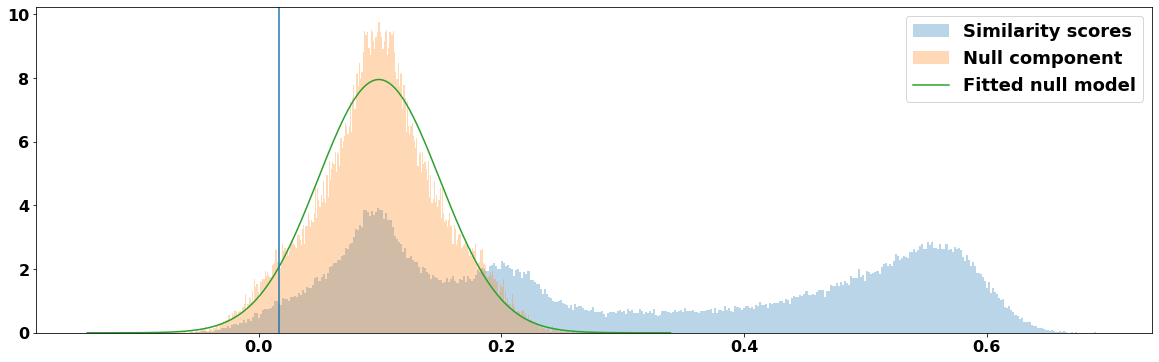

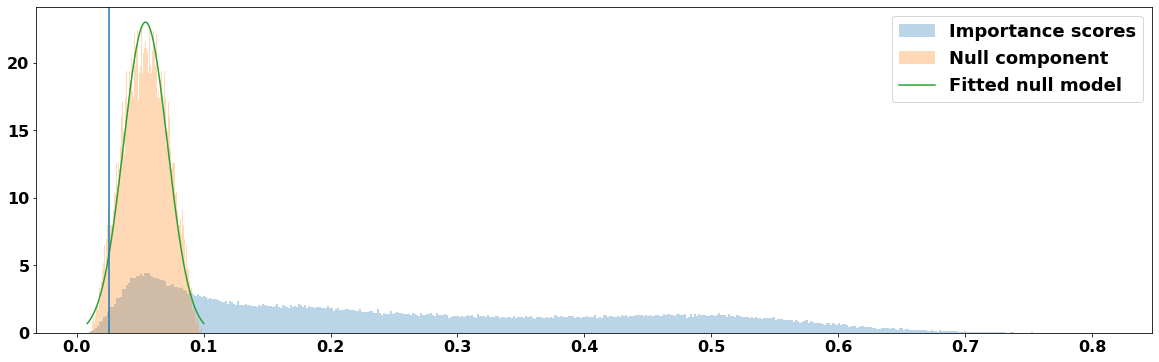

In [164]:
# Filter motif hit table
hit_table_filtered, (sim_score_fig, imp_score_fig) = filter_tfm_peak_hits(
    hit_table, sim_perc_cutoff=motif_tfm_sim_perc_cutoff, imp_perc_cutoff=motif_tfm_imp_perc_cutoff
)

In [165]:
assert not hit_table_filtered.empty, "Filtered out all %d original hits" % len(hit_table)

In [166]:
# Match peaks to motif hits
peak_hits = get_peak_hits(peak_table, hit_table_filtered)

  0%|          | 0/35121 [00:00<?, ?it/s]

In [167]:
# Construct count array of peaks and hits
peak_hit_counts = get_peak_motif_counts(peak_hits, motif_keys)

  0%|          | 0/35828 [00:00<?, ?it/s]

In [168]:
# Construct count matrix of motif co-occurrence
motif_cooccurrence_count_matrix = get_motif_cooccurrence_count_matrix(peak_hit_counts)

In [169]:
# Construct the matrix of p-values for motif co-occurrence
motif_cooccurrence_pval_matrix = compute_cooccurrence_pvals(peak_hit_counts)

In [93]:
if hits_cache_dir:
    # Save the filtered hits in the cache
    hit_table_filtered.reset_index().to_csv(
        os.path.join(hits_cache_dir, "filtered_hits.tsv"), sep="\t", header=True, index=False
    )
    
    # Save the peaks
    peak_table.reset_index().to_csv(
        os.path.join(hits_cache_dir, "peaks.tsv"), sep="\t", header=True, index=False
    )
    
    # Save a mapping between peak index and filtered motif indices
    with open(os.path.join(hits_cache_dir, "peak_matched_hits.tsv"), "w") as f:
        f.write("peak_index\tfiltered_hit_indices\n")
        for i, table in enumerate(peak_hits):
            f.write("%d\t%s\n" % (i, ",".join([str(x) for x in peak_hits[i].index])))
    
    # Save score figures
    sim_score_fig.savefig(os.path.join(hits_cache_dir, "sim_score_dist.png"))
    imp_score_fig.savefig(os.path.join(hits_cache_dir, "imp_score_dist.png"))
    
    # Save co-occurrence matrices
    with h5py.File(os.path.join(hits_cache_dir, "cooccurrences.h5"), "w") as f:
        f.create_dataset("counts", data=motif_cooccurrence_count_matrix, compression="gzip")
        f.create_dataset("pvals", data=motif_cooccurrence_pval_matrix, compression="gzip")

<a id="peaks-with-hits"></a>
### Proportion of peaks with hits

In [170]:
motifs_per_peak = np.array([len(hits) for hits in peak_hits])

In [171]:
display(vdomh.p("Number of peaks: %d" % len(peak_table)))
display(vdomh.p("Number of motif hits before FDR filtering: %d" % len(hit_table)))
display(vdomh.p("Number of motif hits after FDR filtering: %d" % len(hit_table_filtered)))

<p>Number of peaks: 35828</p>

<p>Number of motif hits before FDR filtering: 153497</p>

<p>Number of motif hits after FDR filtering: 148205</p>

In [172]:
num_zero = np.sum(motifs_per_peak == 0)
display(vdomh.p("Number of peaks with 0 motif hits: %d" % num_zero))
display(vdomh.p("Percentage of peaks with 0 motif hits: %.1f%%" % (num_zero / len(peak_table) * 100)))

<p>Number of peaks with 0 motif hits: 707</p>

<p>Percentage of peaks with 0 motif hits: 2.0%</p>

In [173]:
quants = [0, 0.25, 0.50, 0.75, 0.99, 1]
header = vdomh.thead(
    vdomh.tr(
        vdomh.th("Quantile", style={"text-align": "center"}),
        vdomh.th("Number of hits/peak", style={"text-align": "center"})
    )
)
body = vdomh.tbody(*([
    vdomh.tr(
        vdomh.td("%.1f%%" % (q * 100)), vdomh.td("%d" % v)
    ) for q, v in zip(quants, np.quantile(motifs_per_peak, quants))
]))
vdomh.table(header, body)

Quantile,Number of hits/peak
0.0%,0
25.0%,3
50.0%,4
75.0%,5
99.0%,11
100.0%,22


/home/katie/anaconda/envs/modi2/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


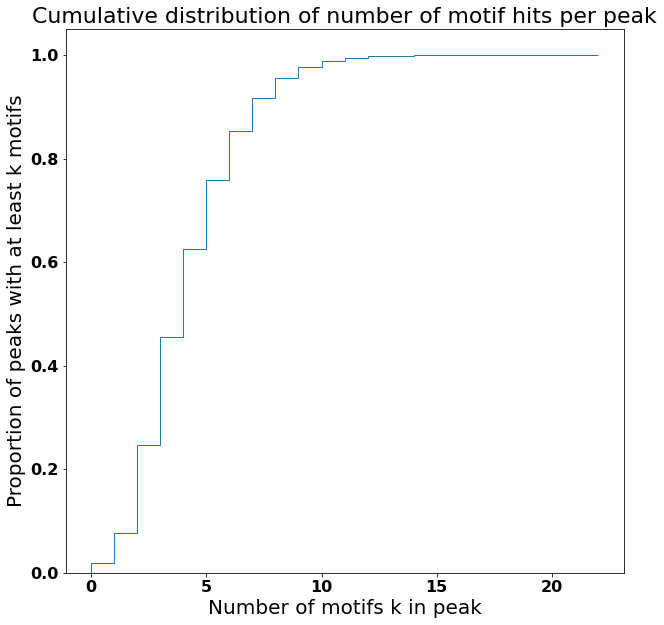

In [174]:
fig, ax = plt.subplots(figsize=(10, 10))
bins = np.concatenate([np.arange(np.max(motifs_per_peak) + 1), [np.inf]])
ax.hist(motifs_per_peak, bins=bins, density=True, histtype="step", cumulative=True)
ax.set_title("Cumulative distribution of number of motif hits per peak")
ax.set_xlabel("Number of motifs k in peak")
ax.set_ylabel("Proportion of peaks with at least k motifs")
plt.show()

if hits_cache_dir:
    fig.savefig(os.path.join(hits_cache_dir, "peak_hit_count_cdf.png"))

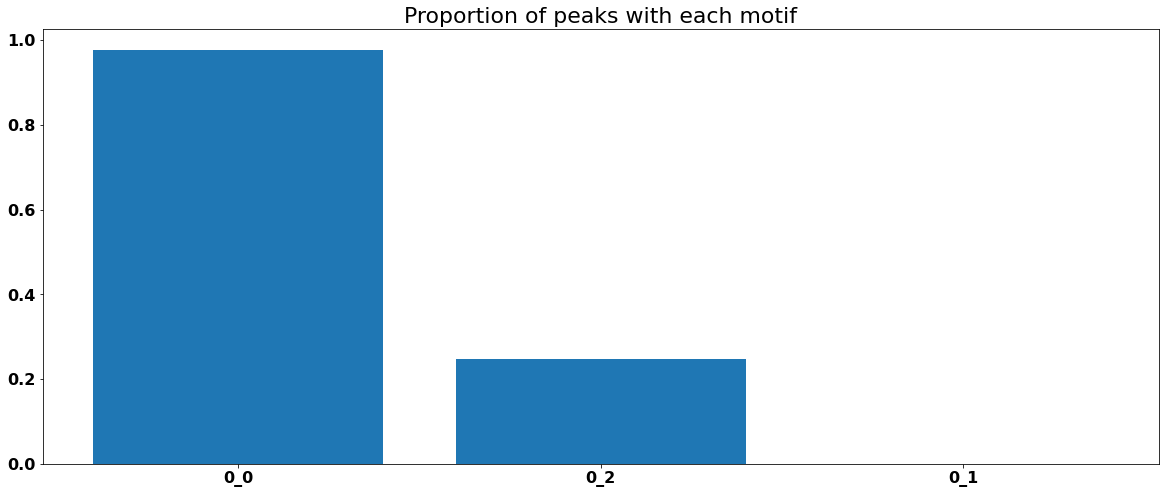

In [175]:
frac_peaks_with_motif = np.sum(peak_hit_counts > 0, axis=0) / len(peak_hit_counts)
labels = np.array(motif_keys)
sorted_inds = np.flip(np.argsort(frac_peaks_with_motif))
frac_peaks_with_motif = frac_peaks_with_motif[sorted_inds]
labels = labels[sorted_inds]

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(np.arange(len(labels)), frac_peaks_with_motif)
ax.set_title("Proportion of peaks with each motif")
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.show()

if hits_cache_dir:
    fig.savefig(os.path.join(hits_cache_dir, "peaks_with_each_motif.png"))

# DID NOT RUN ANYTHING BELOW THIS FOR FEB 7 DATA

<a id="example-hits"></a>
### Examples of motif hits in sequences

In [171]:
# Show some examples of sequences with motif hits
num_to_draw = 3
center_plot_size = 400

unique_counts = np.sort(np.unique(motifs_per_peak))
motif_nums = []
if 0 in motifs_per_peak:
    motif_nums.append(0)
if 1 in motifs_per_peak:
    motif_nums.append(1)
motif_nums.extend([
    unique_counts[0],  # Minimum
    unique_counts[len(unique_counts) // 2],  # Median
    unique_counts[-1],  # Maximum
])

for motif_num in np.sort(np.unique(motif_nums)):
    display(vdomh.h4("Sequences with %d motif hits" % motif_num))
    
    peak_inds = np.where(motifs_per_peak == motif_num)[0]
    table_rows = []
    rng = np.random.RandomState(seed)
    for i in rng.choice(
        peak_inds, size=min(num_to_draw, len(peak_inds)), replace=False
    ):
        peak_coord = peak_table.iloc[i][["chrom", "peak_start", "peak_end"]].values
        motif_hits = peak_hits[i]
        
        chrom, peak_start, peak_end = peak_coord
        
        # Limit peak start/end here
        mid = (peak_start + peak_end) // 2
        peak_start = mid - (center_plot_size // 2)
        peak_end = peak_start + center_plot_size
        
        peak_len = peak_end - peak_start
        mask = (shap_coords[:, 0] == chrom) & (shap_coords[:, 1] <= peak_start) & (shap_coords[:, 2] >= peak_end)
        if not np.sum(mask):
            fig = "No matching input sequence found"
            table_rows.append(
                vdomh.tr(
                    vdomh.td("%s:%d-%d" % (chrom, peak_start, peak_end)),
                    vdomh.td(fig)
                )
            )
            continue
            
        seq_index = np.where(mask)[0][0]  # Pick one
        imp_scores = act_scores[seq_index]
        _, seq_start, seq_end = shap_coords[seq_index]
        
        highlights = []
        for _, row in motif_hits.iterrows():
            start = row["start"] - peak_start
            end = start + (row["end"] - row["start"])
            highlights.append((start, end))
        
        # Remove highlights that overrun the sequence
        highlights = [(a, b) for a, b in highlights if a >= 0 and b < peak_len]
        
        start = peak_start - seq_start 
        end = start + peak_len
        imp_scores_peak = imp_scores[start:end]
        
        fig = viz_sequence.plot_weights(
            imp_scores_peak, subticks_frequency=(len(imp_scores_peak) + 1),
            highlight={"red" : [pair for pair in highlights]},
            return_fig=True
        )
        fig = figure_to_vdom_image(fig)
        
        table_rows.append(
            vdomh.tr(
                vdomh.td("%s:%d-%d" % (chrom, peak_start, peak_end)),
                vdomh.td(fig)
            )
        )

    table = vdomh.table(*table_rows)
    display(table)
    plt.close("all")

<h4>Sequences with 0 motif hits</h4>

chr14:90383094-90383494
chr16:66741284-66741684
chr11:110148572-110148972


<h4>Sequences with 1 motif hits</h4>

chr10:110606103-110606503
chr14:94025899-94026299
chr19:49533137-49533537


<h4>Sequences with 7 motif hits</h4>

chr1:193971507-193971907
chr5:14178607-14179007
chr6:124948143-124948543


<h4>Sequences with 16 motif hits</h4>

chr8:6649111-6649511


<a id="density"></a>
### Homotypic motif densities
For each motif, show how many the motif occurs in each peak

/home/katie/anaconda/envs/modi2/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6773: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


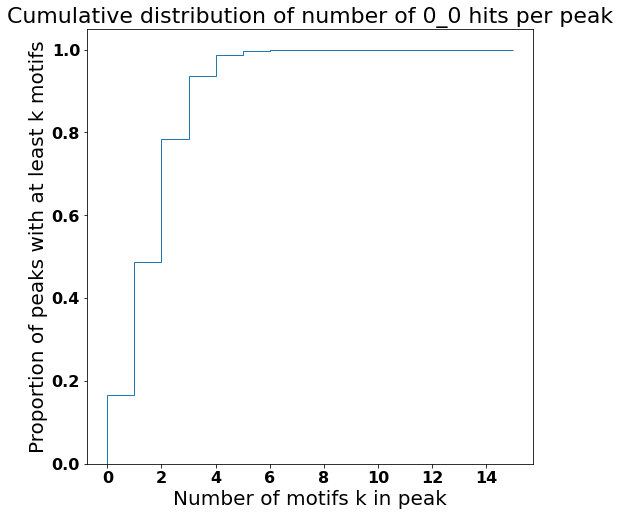

In [172]:
density_figs = plot_homotypic_densities(peak_hit_counts, motif_keys)

if hits_cache_dir:
    for key, fig in density_figs.items():
        fig.savefig(os.path.join(hits_cache_dir, "homotypic_density_%s.png" % key))

<a id="co-occurrence"></a>
### Co-occurrence of motifs
Proportion of time that motifs co-occur with each other in peaks

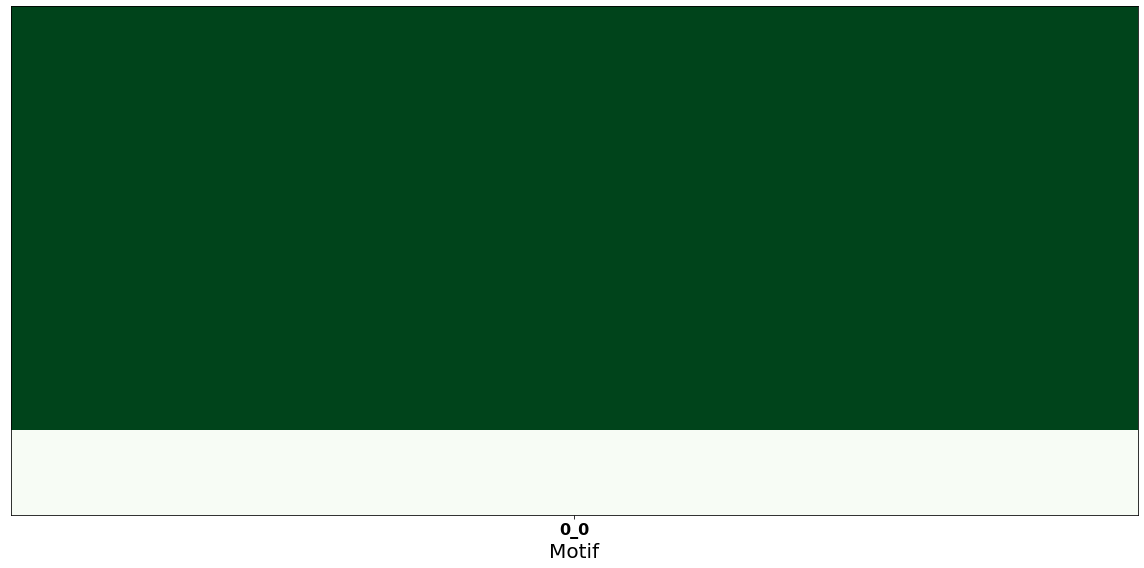

In [173]:
fig = plot_peak_motif_indicator_heatmap(peak_hit_counts, motif_keys, subsample=10000)

if hits_cache_dir:
    fig.savefig(os.path.join(hits_cache_dir, "peak_motif_indicator_heatmap.png"))

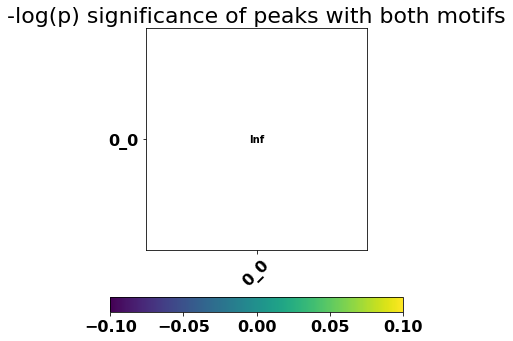

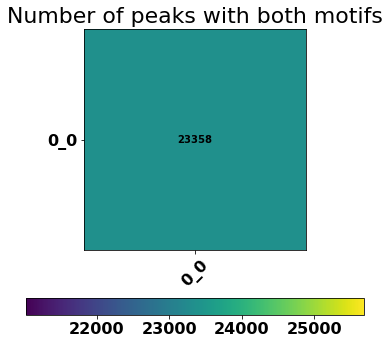

In [174]:
p_fig, c_fig, cluster_inds = plot_motif_cooccurrence_heatmaps(
    motif_cooccurrence_count_matrix, motif_cooccurrence_pval_matrix, motif_keys
)

if hits_cache_dir:
    p_fig.savefig(os.path.join(hits_cache_dir, "cooccurrence_pvals.png"))
    c_fig.savefig(os.path.join(hits_cache_dir, "cooccurrence_counts.png"))

<a id="distance"></a>
### Distribution of distances between motifs
When motifs co-occur, show the distance between the instances

In [175]:
# Get which pairs of motifs are significant
sig_thresh = 1e-6
count_thresh = 100

pvals, sig_pairs = [], []
for i in range(len(motif_keys)):
    for j in range(i + 1):
        if motif_cooccurrence_pval_matrix[i, j] < sig_thresh and motif_cooccurrence_count_matrix[i, j] >= count_thresh:
            sig_pairs.append((i, j))
            pvals.append(motif_cooccurrence_pval_matrix[i, j])
inds = np.argsort(pvals)
sig_pairs = [sig_pairs[i] for i in inds]

  0%|          | 0/1 [00:00<?, ?it/s]

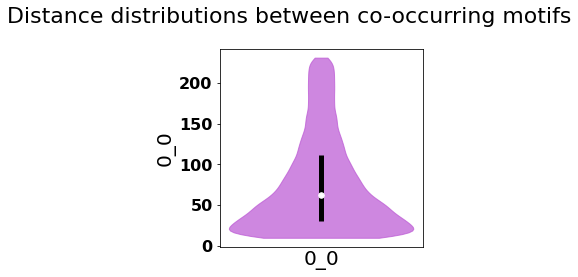

In [176]:
distance_dict, fig = plot_intermotif_distance_violins(peak_hits, motif_keys, sig_pairs, cluster_inds)

if hits_cache_dir:
    if fig is not None:
        with h5py.File(os.path.join(hits_cache_dir, "intermotif_dists.h5"), "w") as f:
            for key_pair, dists in distance_dict.items():
                f.create_dataset("%s:%s" % key_pair, data=dists, compression="gzip")
        fig.savefig(os.path.join(hits_cache_dir, "intermotif_dists.png"))